In [5]:
# import and set parameters
import os
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../')
from models.load_model import load_model, replace_vit_embedding
from src.data.load_dataset import load_dataset
from src.util.load_parser import load_parser
from src.util.load_yaml_config import load_yaml_config
from src.util.seed_torch import seed_torch
from src.util.utils import replace_label
from src.util.util_visualize import convert_image_to_heatmap, make_heatmap

In [2]:
os.chdir('../')
!ls
CONFIG_PATH = './config/config_file_path.yaml'

README.md          evaluate_curve.py  notebook           requirements.txt
config             evaluate_curve.sh  online_identify.py result
data               models             online_identify.sh src


In [3]:
# initialize
args = load_parser()
seed_torch(args.seed)
args.config_path = CONFIG_PATH
config = load_yaml_config(args.config_path)
args.load_image_dir = config["LOAD_IMAGE_DIR"]  
args.save_result_dir = config["SAVE_RESULT_DIR"]
args.label_to_id_path = config['LABEL_TO_ID_PATH']
args.dataset_sampling_number = 100
args.load_image_dir = os.path.join(args.load_image_dir, args.prefix)

# Visualize the heatmap

In [6]:
# initialize
dataset = load_dataset(args)
args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, imageProcessor = load_model(args)
model = replace_vit_embedding(args, model)
model.eval()
replace_dict = None
path = os.path.join(args.save_result_dir, f'online_identify/{args.dataset}_{args.dataset_sampling_number}/{args.model_name}/dataset_index.npy')
dataset_index_list = np.load(path, allow_pickle=True)

/Users/kosuke.sumiyasu/.pyenv/versions/3.9.19/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vit embedding


## Patch Insertion 

In [10]:
# set the plot config
curve_method = 'insertion'
args.model_name = 'vit-t'
start_index = 0
identify_method_list = ['self-shapley', 'MoXI', 'gradcam', 'attention_rollout']
# identify_method_list = ['self-shapley', 'shap+int_self', 'gradcam', 'attention_rollout', 'full-shapley']

['self-shapley', 'MoXI', 'gradcam', 'attention_rollout']


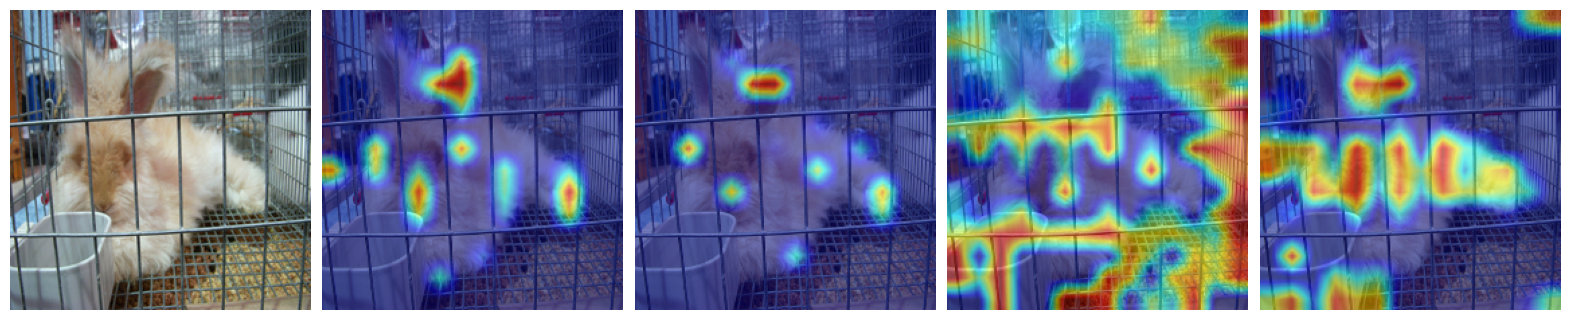

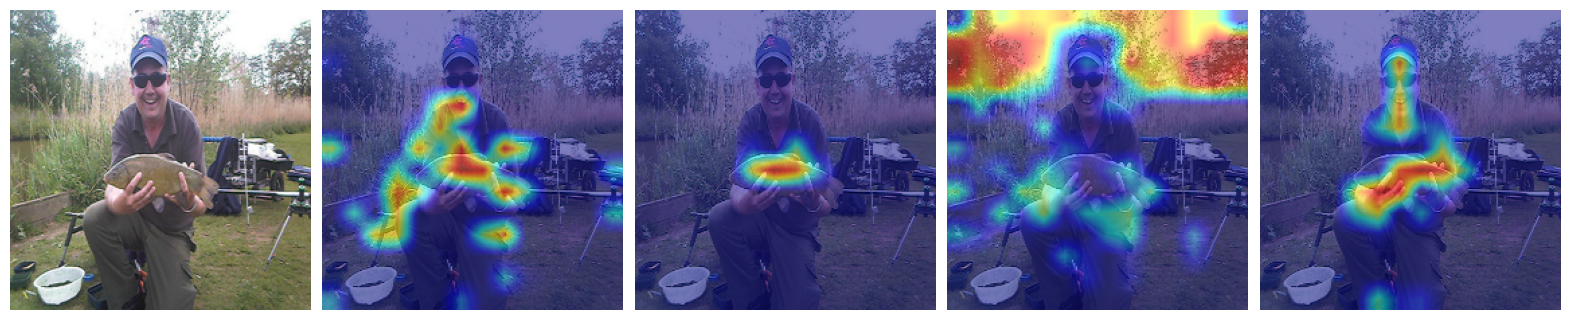

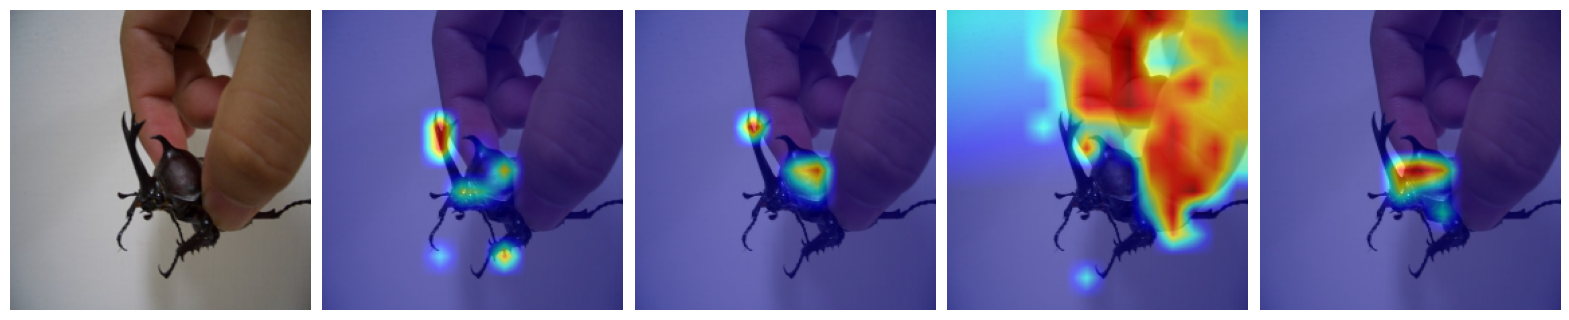

In [18]:
print(identify_method_list)
for dataset_index, dataset_sampling_number in enumerate(dataset_index_list[start_index:start_index+3]):
    count_list = []
    image, label = dataset[dataset_sampling_number]
    plot_images = [image.resize((224, 224))]
    if replace_dict is not None:
        label = replace_label(args, label, replace_dict)
    tensor_label = torch.tensor(label).to(args.device)
    for identify_method in identify_method_list:
        # get the high contribution patches from the identify_method
        # Self-Shapley value and MoXI identify different image patches when applied to the insertion/deletion curves.
        # GradCAM, attention rollout, and full-Shapley identify the same image patches.
        if curve_method == 'deletion' and (identify_method == 'gradcam' or identify_method == 'attention_rollout' or identify_method == 'full-shapley'):
            path = os.path.join(args.save_result_dir, f'online_identify/{args.dataset}_{args.dataset_sampling_number}/{args.model_name}/insertion/{identify_method}/high_contribution_patches.npy')
        else:
            path = os.path.join(args.save_result_dir, f'online_identify/{args.dataset}_{args.dataset_sampling_number}/{args.model_name}/{curve_method}/{identify_method}/high_contribution_patches.npy')
        identify_datadict = np.load(path, allow_pickle=True)
        datadict = identify_datadict[start_index+dataset_index]
        assert datadict['dataset_index'] == dataset_sampling_number
        identified_patch = datadict['identified_patch']
        
        # get the heatmap
        heatmap, count = make_heatmap(args, identified_patch, model, imageProcessor, image, label, curve_method)
        # convert the heatmap to the image
        cam_image = convert_image_to_heatmap(args, image, heatmap)
        plot_images.append(cam_image)
        count_list.append(count)
        
    # plot the heatmap
    fig, axs = plt.subplots(1, len(plot_images), figsize=(4*len(plot_images), 4))
    for i, ax in enumerate(axs.flatten()):
        if i < len(plot_images):
            ax.imshow(plot_images[i])
        ax.axis('off')
    plt.subplots_adjust(wspace=0.04, hspace=0)
    plt.show()

## Patch Deletion

In [15]:
# set the plot config
curve_method = 'deletion'
args.model_name = 'vit-t'
start_index = 20
identify_method_list = ['self-shapley', 'MoXI', 'gradcam', 'attention_rollout']
# identify_method_list = ['self-shapley', 'shap+int_self', 'gradcam', 'attention_rollout', 'full-shapley']

['self-shapley', 'MoXI', 'gradcam', 'attention_rollout']


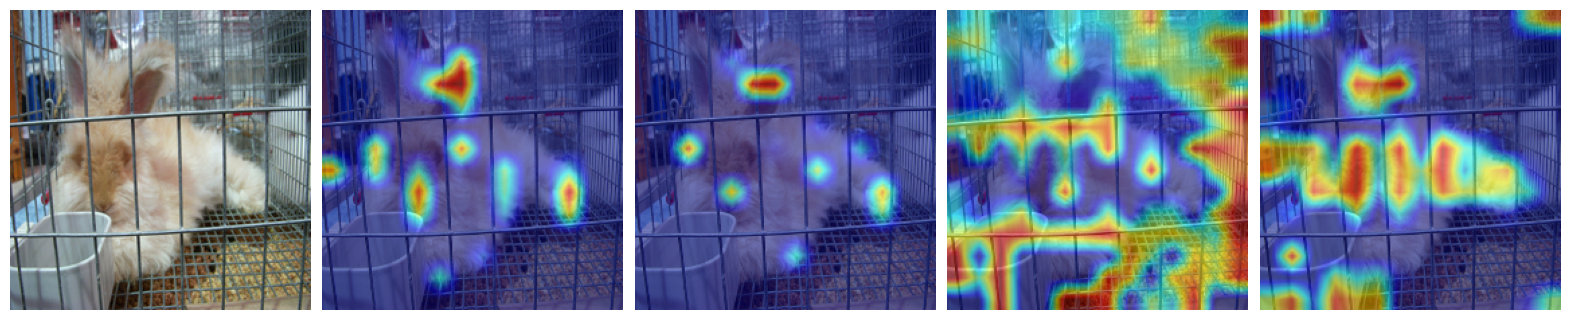

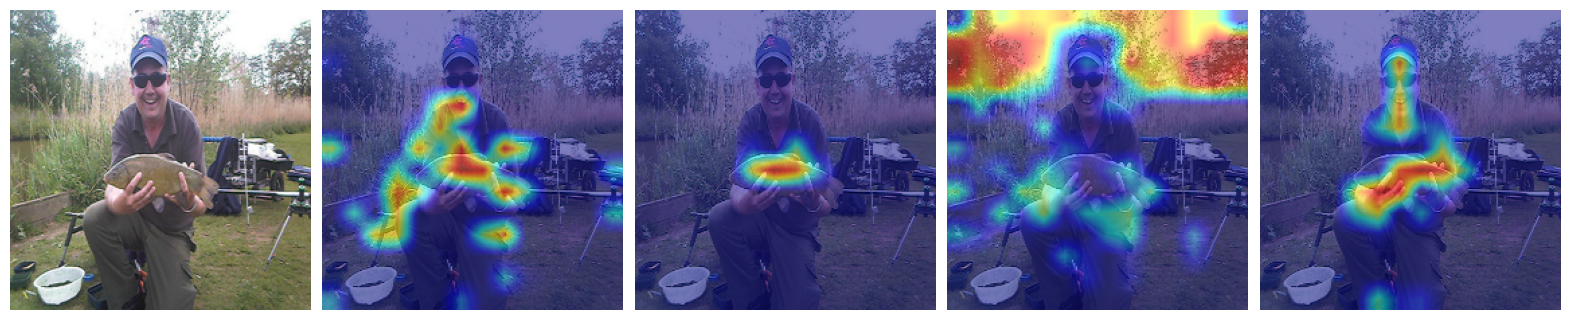

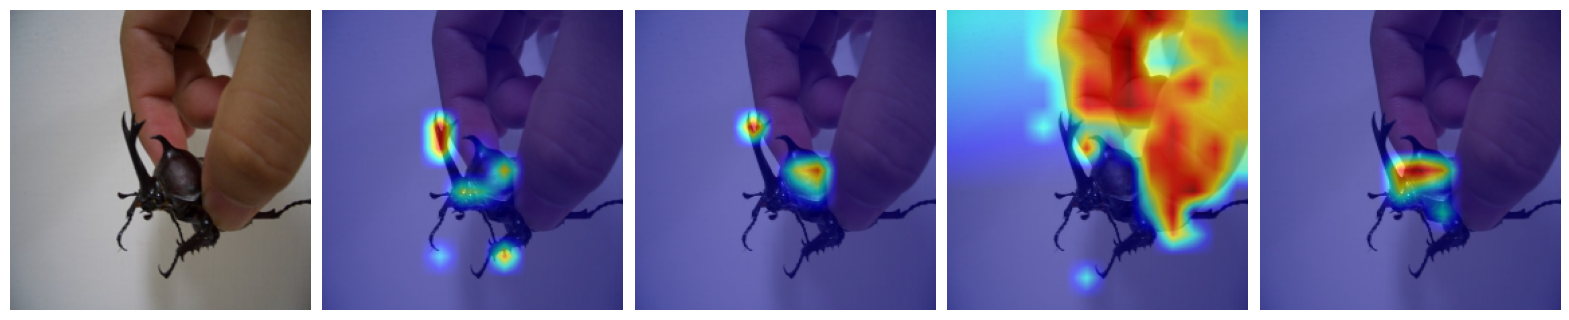

In [19]:
print(identify_method_list)
for dataset_index, dataset_sampling_number in enumerate(dataset_index_list[start_index:start_index+3]):
    count_list = []
    image, label = dataset[dataset_sampling_number]
    plot_images = [image.resize((224, 224))]
    if replace_dict is not None:
        label = replace_label(args, label, replace_dict)
    tensor_label = torch.tensor(label).to(args.device)
    for identify_method in identify_method_list:
        # get the high contribution patches from the identify_method
        # Self-Shapley value and MoXI identify different image patches when applied to the insertion/deletion curves.
        # GradCAM, attention rollout, and full-Shapley identify the same image patches.
        if curve_method == 'deletion' and (identify_method == 'gradcam' or identify_method == 'attention_rollout' or identify_method == 'full-shapley'):
            path = os.path.join(args.save_result_dir, f'online_identify/{args.dataset}_{args.dataset_sampling_number}/{args.model_name}/insertion/{identify_method}/high_contribution_patches.npy')
        else:
            path = os.path.join(args.save_result_dir, f'online_identify/{args.dataset}_{args.dataset_sampling_number}/{args.model_name}/{curve_method}/{identify_method}/high_contribution_patches.npy')
        identify_datadict = np.load(path, allow_pickle=True)
        datadict = identify_datadict[start_index+dataset_index]
        assert datadict['dataset_index'] == dataset_sampling_number
        identified_patch = datadict['identified_patch']
        
        # get the heatmap
        heatmap, count = make_heatmap(args, identified_patch, model, imageProcessor, image, label, curve_method)
        # convert the heatmap to the image
        cam_image = convert_image_to_heatmap(args, image, heatmap)
        plot_images.append(cam_image)
        count_list.append(count)
        
    # plot the heatmap
    fig, axs = plt.subplots(1, len(plot_images), figsize=(4*len(plot_images), 4))
    for i, ax in enumerate(axs.flatten()):
        if i < len(plot_images):
            ax.imshow(plot_images[i])
        ax.axis('off')
    plt.subplots_adjust(wspace=0.04, hspace=0)
    plt.show()